### import packages

In [270]:
import datascience as ds
from datascience import *
import numpy as np
from graphviz import Source
import pandas as pd
import re, string
import nltk
from functools import reduce
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

%matplotlib inline

In [271]:
def process_text(data):
    cleaned_text = [
        re.sub('\s+', ' ', 
               re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|[0-9]+|http.+?", '',
               tweets.lower()).strip(string.punctuation).strip()) for tweets in data
        ]
    return cleaned_text

In [272]:
tagged = pd.read_csv('tagged.csv', sep=',', index_col=False)
tagged.text = process_text(tagged.text)
tagged = tagged.drop(tagged.columns[0], axis=1).reset_index(drop=True)
tagged = tagged.drop(tagged[tagged.sentiment==-1].index).reset_index(drop=True)
tagged = tagged.iloc[tagged.text.drop_duplicates().index]
tagged.to_csv('relevant_tagged.csv')

### tweets data loaded into Jupyter Notebook as Table object

In [273]:
df = ds.Table.read_table('relevant_tagged.csv', sep=',')

### StratifiedKFold

In [274]:
X = list(df['text'])
y = list(df['sentiment'])

#### Model Building

In [275]:
def custom_split(train_index, test_index):
    trainingset = df.take(train_index)
    testingset = df.take(test_index)    
        
    X_train= list(trainingset['text'])
    y_train= list(trainingset['sentiment'])
    X_test= list(testingset['text'])
    y_test= list(testingset['sentiment'])
    
    return X_train, X_test, y_train, y_test

In [251]:
def word_vectorizer(X_train, X_test):
    vect = CountVectorizer(
         analyzer="word", ngram_range=([1,2]), tokenizer=nltk.word_tokenize,
        preprocessor=None, stop_words='english', max_features=3000)
#     vect = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l1', encoding='latin-1', 
#                             ngram_range=(1,2), stop_words='english')
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    return X_train_vect, X_test_vect, vect.get_feature_names()

In [252]:
def classifier(X_train, y_train, X_test, fold, feature_names, max_depth, min_samples_leaf):
    clf = DecisionTreeClassifier(criterion = 'entropy',
                                    random_state = 100,
                                    max_depth = max_depth,
                                    min_samples_leaf = min_samples_leaf)

    clf.fit(X_train, y_train)
    try:
        dot_data = tree.export_graphviz(clf, out_file=None, 
                                        feature_names=feature_names)
        graph = Source(dot_data)
        graph.render('SentientClassifier-Fold_{}_depth{}_leaf_{}'.format(fold, max_depth, min_samples_leaf))
    except Exception as e:
        print(e)
    predicted_y_test = clf.predict(X_test)
    return predicted_y_test

In [253]:
def eval_results(predicted_y_test, y_test):
    precision_s = precision_score(y_test, predicted_y_test, average='weighted')
    recall_s = recall_score(y_test, predicted_y_test, average='weighted')
    f1_s = f1_score(y_test, predicted_y_test, average='weighted')
    cm = confusion_matrix(y_test, predicted_y_test)  
    return precision_s, recall_s, f1_s, cm

In [254]:
def plot_results(res, idx):
    metrics_df = pd.DataFrame(
        {'precision': res[idx].precision_score,
        'recall':res[idx].recall_score,
        'f1':res[idx].f1_score}
        )
    metrics_df.index = np.arange(1,6)
    metrics_df.plot(linewidth=2)
    plt.show()

###  1) Stratified k-fold cross validation results for each combination of max_depth and min_samples_leaf you chose

In [255]:
def k_fold_evaluate(X, y, n_splits, max_depth_tests, min_samples_leaf_tests):

    classes = ['neutral', 'positive', 'negative']
    skf = StratifiedKFold(n_splits=n_splits, random_state=1, shuffle= True)
    
    res = []
    res_total = []
    
    for depth in max_depth_tests:
        for leaf in min_samples_leaf_tests:
            fold = 1
            for train_index, test_index in skf.split(X, y):
                
                X_train, X_test, y_train, y_test = custom_split(train_index, test_index)

                X_train_vect, X_test_vect, feature_names = word_vectorizer(X_train, X_test)

                # print('max_depth = {}'.format(depth))
                # print('min_samples_leaf = {}\n'.format(leaf))
                predicted_y_test = classifier(X_train=X_train_vect, y_train=y_train, 
                                              X_test=X_test_vect, fold=fold, 
                                              feature_names=feature_names,
                                              max_depth=depth,
                                              min_samples_leaf=leaf)
                precision_s, recall_s, f1_s, cm = eval_results(predicted_y_test, y_test)
                
                res.append(['fold{}'.format(fold), depth, leaf, f1_s, precision_s, recall_s])
                fold += 1
                
    res_df = pd.DataFrame(res, columns=['fold', 'max_depth', 'min_samples_leaf', 'f1_score', 'precision_score', 'recall_score'])
    
    for s in ['f1_score', 'precision_score', 'recall_score']:
        max_score = np.array(res_df.groupby(by='fold').apply(lambda x: x[s].values.argmax()).values)
        res_total.append(pd.DataFrame([res_df[res_df.fold=='fold{}'.format(i)].iloc[max_score[i-1], :] for i in range(1,6)]))
        
    return res_total

In [256]:
max_depth_tests = np.arange(5, 15, 1)
min_samples_leaf_tests = np.arange(1, 5, 1)
res_total = k_fold_evaluate(X, y, n_splits=5, max_depth_tests=max_depth_tests, min_samples_leaf_tests=min_samples_leaf_tests)

#### when reach max f1 score in each fold: 

In [269]:
print(res_total[0].to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &   fold &  max\_depth &  min\_samples\_leaf &  f1\_score &  precision\_score &  recall\_score \\
\midrule
155 &  fold1 &         12 &                 4 &  0.435166 &         0.717057 &      0.507389 \\
161 &  fold2 &         13 &                 1 &  0.428888 &         0.709975 &      0.497537 \\
182 &  fold3 &         14 &                 1 &  0.448121 &         0.743648 &      0.514851 \\
183 &  fold4 &         14 &                 1 &  0.440867 &         0.741167 &      0.509901 \\
164 &  fold5 &         13 &                 1 &  0.401043 &         0.700211 &      0.485149 \\
\bottomrule
\end{tabular}



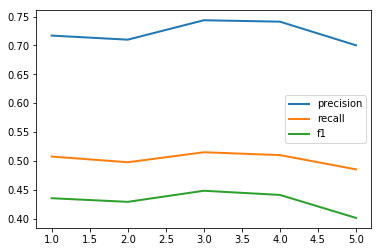

In [258]:
plot_results(res_total, idx=0)

#### when reach max precision score in each fold:

In [266]:
print(res_total[1].to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &   fold &  max\_depth &  min\_samples\_leaf &  f1\_score &  precision\_score &  recall\_score \\
\midrule
20  &  fold1 &          6 &                 1 &  0.334993 &         0.771800 &      0.448276 \\
1   &  fold2 &          5 &                 1 &  0.335450 &         0.771800 &      0.448276 \\
182 &  fold3 &         14 &                 1 &  0.448121 &         0.743648 &      0.514851 \\
23  &  fold4 &          6 &                 1 &  0.358025 &         0.774925 &      0.460396 \\
164 &  fold5 &         13 &                 1 &  0.401043 &         0.700211 &      0.485149 \\
\bottomrule
\end{tabular}



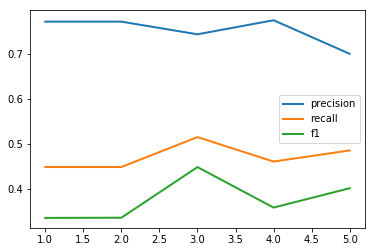

In [260]:
plot_results(res_total, idx=1)

#### when reach max recall score in each fold:

In [268]:
print(res_total[2].to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &   fold &  max\_depth &  min\_samples\_leaf &  f1\_score &  precision\_score &  recall\_score \\
\midrule
155 &  fold1 &         12 &                 4 &  0.435166 &         0.717057 &      0.507389 \\
151 &  fold2 &         12 &                 3 &  0.419940 &         0.732016 &      0.497537 \\
182 &  fold3 &         14 &                 1 &  0.448121 &         0.743648 &      0.514851 \\
183 &  fold4 &         14 &                 1 &  0.440867 &         0.741167 &      0.509901 \\
164 &  fold5 &         13 &                 1 &  0.401043 &         0.700211 &      0.485149 \\
\bottomrule
\end{tabular}



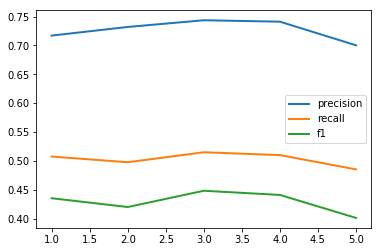

In [262]:
plot_results(res_total, idx=2)

### 2) discuss common features across the trees generated for each k-fold cross validation (include visualization of exemplar trees)

Here we display the tree in randomly chosen folds that reaches the highest f1, precision and recall scores:



- Fold 1: max_depth = 12, min_samples_leaf = 4

![](fold1_14_1.png)


- Fold 1: max_depth = 6, min_samples_leaf = 1

![](fold1_6_1.png)


- Fold 5: max_depth = 13, min_samples_leaf = 1

![](fold5_13_1.png)



- Decision Trees of different combination of max_depth and min_samples_leaf and different folds share some similar features, for instance:
    - $great \le 5$ is the root node of all the sampled trees here
    - $illegal \le 0.5, good \le 0.5$ also appears in all sampled trees
    - $crazy \le 0.5, deep \le 0.5$ appears in not all but also more than 1 tree


### 3) discuss the results (e.g., the best combination of max_depth and min_samples_leaf)

To summarize, when $\text{max_depth} \in [1,15], \text{min_samples_leaf} \in [1,5]$

$$\text{ max_depth }= 14$$

$$\text{ min_samples_leaf } = 1 $$

or 

$$\text{ max_depth }= 13$$

$$\text{ min_samples_leaf } = 1 $$

are probably the optimal choice since in the 5 fold cross validation, these combination reach:
- 14, 1
    - the highest f1 score in fold3 and fold4
    - the highest precision score in fold3
    - the highest recall score in fold3 and fold4
- 13, 1
    - the highest f1 score in fold2 and fold5
    - the highest precision score in fold5
    - the highest recall score in fold5